# RF/GB modeling
* Used Functions
-- BlockingTimeSeriesSplit(): make train-validation split object
& plot_cv_indices(): plot block split results
** reference : https://gmnam.tistory.com/230#:~:text=class%20BlockingTimeSeriesSplit%28%29%3A%20def%20__init__%28self%2C%20n_splits%29%3A%20self.n_splits%20%3D%20n_splits,indices%20%5Bstart%3A%20mid%5D%2C%20indices%20%5Bmid%20%2B%20margin%3A%20stop%5D
-- make_split(): train-validation split using BlockedTimeSeriesSplit() object
-- classification_report_csv(): convert classification report into dataframe
-- rf_grid_search(): execute grid search for rf model and save the models and performance results in clf_{target type}_rf.pkl in the model folder
-- gb_grid_search(): execute grid search for gb model and save the models and performance results in clf_{target type}_gb.pkl in the model folder

##1. RF model
* RF model trained with all features(45 features)
* RF model trained with top 10 features extraced from the previous model

##2. GB model
* GB model trained with all features(45 features)
* GB model trained with top 10 features extraced from the previous model

## Set up

In [130]:
import os
import random
import tempfile
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

In [131]:
## set the random seed for reproducibility

np.random.seed(699)

os.environ['PYTHONHASHSEED'] = '0'
random.seed(699)

In [132]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
path='drive/MyDrive/Capstone(Team10)/code'

#file = tf.keras.utils
raw_df = pd.read_csv(path+'/data/rawdata_USA.csv', index_col=0, parse_dates=True)
raw_df.index.name='date'
metadata=pd.read_csv(path+'/data/metadata_final.csv')

raw_df.tail(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,BNBUCT02,BNEMTE02,BNODTE02,BNRMTE02,BSCICP02,BSCURT02,BSEMFT02,BSOBLV02,BSOITE02,BSPRTE02,...,BBBOASPREAD,SP500,WTI,W875RX1,VIXCLS,RECPROUSM156N,DXY,y_nber,y_oecd,y_agg
date,,,,,,,,,,,,,,,,,,,,,
2023-02-01,NaN,NaN,NaN,NaN,-2.6,78.4,-1.488108,-10.0,-9.904271,-6.838155,...,1.55,3970.153442,76.83,14622.7,20.12,0.36,104.870003,0,0.0,0.0
2023-03-01,NaN,NaN,NaN,NaN,-3.7,77.8,-4.394159,-10.0,-11.664475,-4.339667,...,1.77,4109.312445,73.28,14664.3,21.64,0.32,102.510002,0,0.0,0.0
2023-04-01,NaN,NaN,NaN,NaN,-2.9,78.4,-0.707885,-11.0,-10.242475,-4.047127,...,1.73,4169.481401,79.45,14659.0,17.82,0.22,101.669998,0,0.0,0.0
2023-05-01,NaN,NaN,NaN,NaN,-3.1,78.4,2.680256,-13.0,-17.834084,1.060291,...,1.80,4179.825462,71.58,14702.7,17.64,0.62,104.320000,0,0.0,0.0
2023-06-01,NaN,NaN,NaN,NaN,-4.0,NaN,-5.300056,-9.0,-6.879287,-6.892674,...,1.69,4450.381312,68.11,NaN,14.00,NaN,102.910004,0,0.0,0.0


In [133]:
with open(path+'/data/X_data_full.pkl','rb') as f:
  X_data=pickle.load(f)
X_data.tail(5)

,LCEAPR01,XTIMVA01,PRMNTO01,MABMM301,PRCNTO01,STMNIS01,SLWHTO02,ODMNTO02,XTEXVA01,CCRETT01,...,IRLTLT01,IR3TCD01,BSPRTE02,LREMTTTT,LRHU24TT,LRUNTTTT,BSCURT02,3MTBILL,10YT,103SPREAD
date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,0.003972,-0.012969,0.001926,-0.002016,-0.011827,0.000000,0.001179,-0.000768,-0.006967,-0.004720,...,0.00,0.26,-3.838744,0.2,0.1,0.2,0.1,0.40,0.00,0.27
2022-09-01,0.003597,0.006185,0.002410,-0.006239,-0.005621,0.000000,0.000236,0.001401,-0.008610,0.022638,...,0.62,0.45,-0.266136,0.0,0.3,-0.2,0.1,0.50,0.62,0.39
2022-10-01,0.003942,0.010324,0.001324,-0.004279,-0.003519,-0.006826,-0.001735,0.009146,-0.024849,0.015102,...,0.46,0.64,0.956603,-0.1,-0.2,0.2,0.0,0.59,0.46,0.26
2022-11-01,0.004639,-0.066192,-0.007479,-0.001555,0.006387,0.006826,-0.009899,-0.024357,-0.016453,-0.022972,...,-0.09,0.61,-0.381415,-0.1,0.1,-0.1,-0.6,0.43,-0.09,-0.26
2022-12-01,0.004263,0.020032,-0.021487,-0.001913,-0.000711,0.013514,-0.003170,0.010401,-0.016181,-0.023995,...,-0.27,0.05,-4.533289,0.2,0.0,-0.1,-1.8,0.10,-0.27,-0.63


In [134]:
from sklearn.model_selection import TimeSeriesSplit
from matplotlib.patches import Patch
import matplotlib.pyplot as plt

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
plt.style.use('fivethirtyeight')

class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

def plot_cv_indices(cv, X, n_splits, lw=10):

    fig, ax = plt.subplots()
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.1, -.1], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)

    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
          ['Testing set', 'Training set'], loc=(1.02, .8))

In [135]:
## make index for train, validation dataset
def make_split(X_data, n_splits, test_year):
  train_idxs=[]
  val_idxs=[]

  tss=BlockingTimeSeriesSplit(n_splits=n_splits)

  for train_idx, val_idx in tss.split(X_data[:-(test_year*12)]):
    train_idxs.append(train_idx)
    val_idxs.append(val_idx)

  return train_idxs, val_idxs

In [136]:
## convert classification report into dataframe
def classification_report_csv(report):
    report_data = []
    lines = report.split('\n')

    for line in lines[2:len(lines)-5]:
        row = {}
        row_data = [val for val in line.split(' ') if val!='']
        row['class'] = round(float(row_data[0]),0)
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        row['accuracy']=float([val for val in lines[-4].split(' ') if val!=''][-2])
        report_data.append(row)

    df = pd.DataFrame(report_data)
    return df

## 1. Random Forest(RF) Modeling



### 1-1. RF model trained with all features(45 features)
#### define function for random forest grid search

In [137]:
def rf_grid_search(path, X_data, y_data, y_type, n_splits, test_year, param_rf):

  X_train=X_data.iloc[:-test_year*12]
  y_train=y_data.iloc[:-test_year*12]
  X_test=X_data.iloc[-test_year*12:]
  y_test=y_data.iloc[-test_year*12:]

  tss=BlockingTimeSeriesSplit(n_splits=n_splits)

  model = GridSearchCV(RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=699),
                     param_rf, cv=tss,
                     verbose=3, n_jobs=-1, scoring=['recall_macro'],  ##'recall_macro'
                     refit='recall_macro'
                     )

  clf = make_pipeline(StandardScaler(), model)

  clf.fit(X_train, y_train)

  y_pred_prob=clf.predict_proba(X_test)
  y_pred = clf.predict(X_test)

  clf_report=classification_report(y_test, y_pred)

  param=model.cv_results_['params']
  mean_test_score=model.cv_results_['mean_test_recall_macro']
  std_test_score=model.cv_results_['std_test_recall_macro']
  rank_test_score=model.cv_results_['rank_test_recall_macro']

  for idx, x in enumerate(param):
      x['model']='RF'
      x['y_type']=y_type
      x['mean_test_recall_macro']=mean_test_score[idx]
      x['std_test_recall_macro']=std_test_score[idx]
      x['rank_test_recall_macro']=rank_test_score[idx]

  df_cvresult=pd.DataFrame(param)

  with open (path+'/model/clf_{}_rf.pkl'.format(y_type), 'wb') as f:
      pickle.dump([clf, df_cvresult, y_pred, y_pred_prob, clf_report], f)

#### execute grid search for rf model with full features

In [138]:
## execute grid search
########### assign hyperparameters in interest #############################################################
param_rfs=[{'n_estimators':[30,50,70,100],
            'max_features':[0.2, 0.3, 0.5, 0.7],
            'max_depth':[5,10, None],
            'class_weight':['balanced','balanced_subsample',None],
            }]
y_types=['y_oecd']
test_year=5
n_splits=3
threshold=50
############################################################################################################

for param_rf in param_rfs:
  for y_type in y_types:
    y=raw_df[y_type]
    y_data=y[-(threshold*12+6):-6]
    rf_grid_search(path, X_data, y_data, y_type, n_splits, test_year, param_rf)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


#### find out the best parameter combination for rf model with full features

In [139]:
y_types=['y_oecd'] #,'y_agg']

dict_rf={}

for y_type in y_types:
  with open (path+'/model/clf_{}_rf.pkl'.format(y_type), 'rb') as f:
      [clf, df_cvresult, y_pred, y_pred_prob, clf_report]=pickle.load(f)
      dict_rf['clf_{}_rf.pkl'.format(y_type)]=[clf, df_cvresult, y_pred, y_pred_prob, clf_report]

for idx, model in enumerate(dict_rf):
    if idx==0:
        df_rf=dict_rf[model][1]
    else:
        df_tmp=dict_rf[model][1]
        df_rf=pd.concat([df_rf, df_tmp])

df_rf[df_rf.rank_test_recall_macro==1]

,class_weight,max_depth,max_features,n_estimators,model,y_type,mean_test_recall_macro,std_test_recall_macro,rank_test_recall_macro
12,balanced,5.0,0.7,30,RF,y_oecd,0.620968,0.034495,1


#### find out the performance of the best model for the final test dataset

In [140]:
for idx, model in enumerate(dict_rf.keys()):

    report=dict_rf[model][-1]
    y_pred=dict_rf[model][-3]
    y_test=y_data.iloc[-test_year*12:]

    auc=roc_auc_score(y_test, y_pred)

    if idx==0:
        df_rf_creport=classification_report_csv(report)
        df_rf_creport['model']=model
        df_rf_creport['roc_auc']=auc
    else:
        df_tmp=classification_report_csv(report)
        df_tmp['model']=model
        df_rf_creport=pd.concat([df_rf_creport, df_tmp])
        df_rf_creport['roc_auc']=auc

df_rf_creport

,class,precision,recall,f1_score,support,accuracy,model,roc_auc
0,0.0,0.95,0.7,0.80,56.0,0.68,clf_y_oecd_rf.pkl,0.598214
1,1.0,0.11,0.5,0.17,4.0,0.68,clf_y_oecd_rf.pkl,0.598214


#### figure out top features and recession probabilities of the best model

In [141]:
clf[1].best_estimator_.feature_importances_

array([0.01415617, 0.01542865, 0.1132387 , 0.01497572, 0.03341253,
       0.01363509, 0.01593513, 0.01271353, 0.00558344, 0.01037417,
       0.01000485, 0.0163177 , 0.00666517, 0.01148281, 0.01321243,
       0.02625077, 0.12205775, 0.01450175, 0.01128309, 0.00667398,
       0.01696384, 0.02383768, 0.00935649, 0.00891312, 0.03317872,
       0.00641469, 0.04061953, 0.01070257, 0.01452517, 0.01067692,
       0.02421519, 0.00086366, 0.0078653 , 0.01253587, 0.06833815,
       0.01734252, 0.03217553, 0.00919167, 0.00656914, 0.00859779,
       0.00446429, 0.02921092, 0.02004112, 0.00962818, 0.08586852])

In [142]:
rf_probs = list(clf[1].best_estimator_.predict_proba(X_data))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


,name,feat_imp,description
0,PRINTO01,0.122058,Production Industry Total industry Total indus...
1,PRMNTO01,0.113239,Production Manufacturing Total manufacturing T...
2,103SPREAD,0.085869,10YT-3MTBILL
3,IRSTFR01,0.068338,Interest Rates Immediate rates (< 24 hrs) Fede...
4,W875RX1,0.040620,Real personal income excluding current transfe...
5,PRCNTO01,0.033413,Production Construction Total construction Total
6,CPGRLE01,0.033179,Consumer Price Index OECD Groups All items non...
7,IR3TCD01,0.032176,Interest Rates 3-month or 90-day rates and yie...
8,BSCURT02,0.029211,Business tendency surveys (manufacturing) Capa...
9,CPALTT01,0.026251,Consumer Price Index All items Total Total


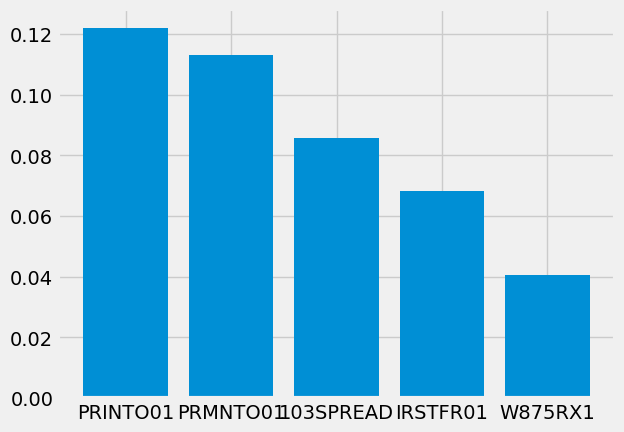

In [143]:
lab_feat_imp = list(zip(list(X_data.columns), list(clf[1].best_estimator_.feature_importances_)))
rf_feats=[x for (x, y) in sorted(lab_feat_imp, key=lambda x: x[1], reverse=True)][:10]

rf_feat_df=pd.DataFrame(sorted(lab_feat_imp, key=lambda x: x[1], reverse=True), columns=['name','feat_imp'])

plt.bar(rf_feat_df.name[:5], rf_feat_df.feat_imp[:5])

rf_feat_df['description']=rf_feat_df['name'].apply(lambda x:metadata[metadata.SUBJECT==x]['Name'].values[0])
rf_feat_df.iloc[:10]

### 1-2. RF model trained with top 10 features

#### set X_data having top 10 features of the previous model

In [144]:
rf_data = X_data[rf_feats]

#### execute grid search for rf model with top 10 features

In [145]:
## execute grid search
########### assign hyperparameters in interest #############################################################
param_rfs=[{'n_estimators':[30,50,70,100],
            'max_features':[0.2, 0.3, 0.5, 0.7],
            'max_depth':[5, 10, None],
            'class_weight':['balanced','balanced_subsample',None]
            }]
y_types=['y_oecd']
test_year=5
n_splits=3
threshold=50
############################################################################################################

for param_rf in param_rfs:
  for y_type in y_types:
    y=raw_df[y_type]
    y_data=y[-(threshold*12+6):-6]
    rf_grid_search(path, rf_data, y_data, y_type, n_splits, test_year, param_rf)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


#### find out the best parameter combination for rf model with top 10 features

In [146]:
y_types=['y_oecd']
dict_rf={}

for y_type in y_types:
  with open (path+'/model/clf_{}_rf.pkl'.format(y_type), 'rb') as f:
      [clf, df_cvresult, y_pred, y_pred_prob, clf_report]=pickle.load(f)
      dict_rf['clf_{}_rf.pkl'.format(y_type)]=[clf, df_cvresult, y_pred, y_pred_prob, clf_report]

for idx, model in enumerate(dict_rf):
    if idx==0:
        df_rf=dict_rf[model][1]
    else:
        df_tmp=dict_rf[model][1]
        df_rf=pd.concat([df_rf, df_tmp])

df_rf[df_rf.rank_test_recall_macro==1]

,class_weight,max_depth,max_features,n_estimators,model,y_type,mean_test_recall_macro,std_test_recall_macro,rank_test_recall_macro
52,balanced_subsample,5.0,0.3,30,RF,y_oecd,0.620968,0.034495,1


#### find out the performance of the best model for the final test dataset

In [147]:
for idx, model in enumerate(dict_rf.keys()):

    report=dict_rf[model][-1]
    y_pred=dict_rf[model][-3]
    y_test=y_data.iloc[-test_year*12:]

    auc=roc_auc_score(y_test, y_pred)

    if idx==0:
        df_rf_creport=classification_report_csv(report)
        df_rf_creport['model']=model
        df_rf_creport['roc_auc']=auc
    else:
        df_tmp=classification_report_csv(report)
        df_tmp['model']=model
        df_rf_creport=pd.concat([df_rf_creport, df_tmp])
        df_rf_creport['roc_auc']=auc

df_rf_creport

,class,precision,recall,f1_score,support,accuracy,model,roc_auc
0,0.0,0.95,0.62,0.75,56.0,0.62,clf_y_oecd_rf.pkl,0.5625
1,1.0,0.09,0.50,0.15,4.0,0.62,clf_y_oecd_rf.pkl,0.5625


#### figure out top features and recession probabilities of the best model

,name,feat_imp
0,Production Industry Total industry Total indus...,0.162139
1,10YT-3MTBILL,0.127522
2,Interest Rates Immediate rates (< 24 hrs) Fede...,0.121092
3,Business tendency surveys (manufacturing) Capa...,0.098280
4,Production Manufacturing Total manufacturing T...,0.095144
5,Interest Rates 3-month or 90-day rates and yie...,0.094399
6,Real personal income excluding current transfe...,0.093668
7,Consumer Price Index All items Total Total,0.074078
8,Consumer Price Index OECD Groups All items non...,0.073214
9,Production Construction Total construction Total,0.060463


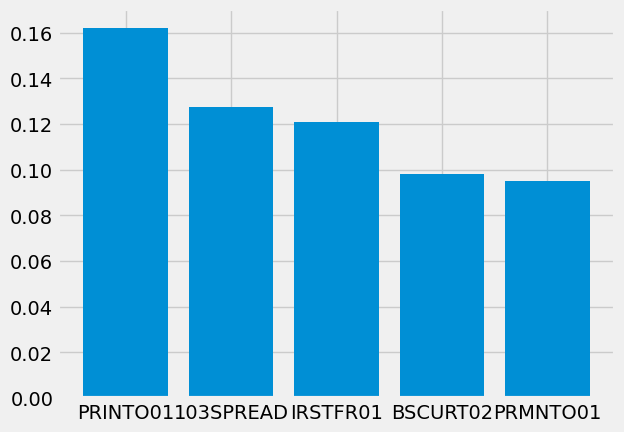

In [148]:
lab_feat_imp = list(zip(list(rf_data.columns), list(clf[1].best_estimator_.feature_importances_)))

rf_feat_df_top=pd.DataFrame(sorted(lab_feat_imp, key=lambda x: x[1], reverse=True), columns=['name','feat_imp'])

plt.bar(rf_feat_df_top.name[:5], rf_feat_df_top.feat_imp[:5])

rf_feat_df_top['name']=rf_feat_df_top['name'].apply(lambda x:metadata[metadata.SUBJECT==x]['Name'].values[0])
rf_feat_df_top


In [149]:
rf_sel_probs = list(clf[1].best_estimator_.predict_proba(rf_data))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


##2. Gradient Boosting(GB) Modeling


### 2-1. GB model trained with all features(45 features)
#### define function for random forest grid search


In [150]:
def gb_grid_search(path, X_data, y_data, y_type, n_splits, test_year, param_gb):

  X_train=X_data.iloc[:-test_year*12]
  y_train=y_data.iloc[:-test_year*12]
  X_test=X_data.iloc[-test_year*12:]
  y_test=y_data.iloc[-test_year*12:]

  tss=BlockingTimeSeriesSplit(n_splits=n_splits)

  model = GridSearchCV(GradientBoostingClassifier(random_state=699),
                     param_gb, cv=tss,
                     verbose=3, n_jobs=-1, scoring=['recall_macro'],
                     refit='recall_macro'
                     )

  clf = make_pipeline(StandardScaler(), model)

  clf.fit(X_train, y_train)

  y_pred_prob=clf.predict_proba(X_test)
  y_pred = clf.predict(X_test)

  clf_report=classification_report(y_test, y_pred)

  param=model.cv_results_['params']
  mean_test_score=model.cv_results_['mean_test_recall_macro']
  std_test_score=model.cv_results_['std_test_recall_macro']
  rank_test_score=model.cv_results_['rank_test_recall_macro']

  for idx, x in enumerate(param):
      x['model']='GB'
      x['y_type']=y_type
      x['mean_test_recall_macro']=mean_test_score[idx]
      x['std_test_recall_macro']=std_test_score[idx]
      x['rank_test_recall_macro']=rank_test_score[idx]

  df_cvresult=pd.DataFrame(param)

  with open (path+'/model/clf_{}_gb.pkl'.format(y_type), 'wb') as f:
      pickle.dump([clf, df_cvresult, y_pred, y_pred_prob, clf_report], f)

#### execute grid search for gb model with full features

In [151]:
## execute grid search
########### assign hyperparameters in interest #############################################################
param_gbs=[{'n_estimators':[30, 40, 60, 100],
            'max_depth':[5, 10],
            'learning_rate':[0.2, 0.3, 0.5, 0.7],
            'max_features':[0.3, 0.4, 0.6, 0.8],
            }]
y_types=['y_oecd']
test_year=5
n_splits=3
threshold=50
############################################################################################################

for param_gb in param_gbs:
  for y_type in y_types:
    y=raw_df[y_type]
    y_data=y[-(threshold*12+6):-6]
    gb_grid_search(path, X_data, y_data, y_type, n_splits, test_year, param_gb)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


#### find out the best parameter combination for gb model with full features

In [152]:
y_types=['y_oecd']

dict_gb={}

for y_type in y_types:
  with open (path+'/model/clf_{}_gb.pkl'.format(y_type), 'rb') as f:
      [clf, df_cvresult, y_pred, y_pred_prob, clf_report]=pickle.load(f)
      dict_gb['clf_{}_gb.pkl'.format(y_type)]=[clf, df_cvresult, y_pred, y_pred_prob, clf_report]

for idx, model in enumerate(dict_gb):
    if idx==0:
        df_gb=dict_gb[model][1]
    else:
        df_tmp=dict_gb[model][1]
        df_gb=pd.concat([df_gb, df_tmp])

df_gb[df_gb.rank_test_recall_macro==1]

,learning_rate,max_depth,max_features,n_estimators,model,y_type,mean_test_recall_macro,std_test_recall_macro,rank_test_recall_macro
32,0.3,5,0.3,30,GB,y_oecd,0.605411,0.11878,1


#### find out the performance of the best model for the final test dataset

In [153]:
for idx, model in enumerate(dict_gb.keys()):

    report=dict_gb[model][-1]
    y_pred=dict_gb[model][-3]
    y_test=y_data.iloc[-test_year*12:]

    auc=roc_auc_score(y_test, y_pred)

    if idx==0:
        df_gb_creport=classification_report_csv(report)
        df_gb_creport['model']=model
        df_gb_creport['roc_auc']=auc
    else:
        df_tmp=classification_report_csv(report)
        df_tmp['model']=model
        df_gb_creport=pd.concat([df_gb_creport, df_tmp])
        df_gb_creport['roc_auc']=auc

df_gb_creport

,class,precision,recall,f1_score,support,accuracy,model,roc_auc
0,0.0,0.96,0.79,0.86,56.0,0.77,clf_y_oecd_gb.pkl,0.642857
1,1.0,0.14,0.50,0.22,4.0,0.77,clf_y_oecd_gb.pkl,0.642857


#### figure out top features and recession probabilities of the best model

In [154]:
clf[1].best_estimator_.feature_importances_

array([0.00963187, 0.02729192, 0.11682216, 0.03014066, 0.03021836,
       0.01422738, 0.01275677, 0.01290824, 0.00094973, 0.00629908,
       0.01284094, 0.01602108, 0.01046351, 0.01465227, 0.0255597 ,
       0.04246384, 0.05758826, 0.02503974, 0.00617208, 0.0178613 ,
       0.00299874, 0.03688334, 0.00915182, 0.0093631 , 0.02406281,
       0.00626734, 0.04332951, 0.02217036, 0.01032755, 0.01426751,
       0.04090184, 0.00775272, 0.00392555, 0.03273933, 0.03185296,
       0.0090657 , 0.03212833, 0.01590173, 0.00159299, 0.00657309,
       0.00334023, 0.03177023, 0.03701481, 0.01429952, 0.06241   ])

,name,feat_imp
0,Production Manufacturing Total manufacturing T...,0.116822
1,10YT-3MTBILL,0.062410
2,Production Industry Total industry Total indus...,0.057588
3,Real personal income excluding current transfe...,0.043330
4,Consumer Price Index All items Total Total,0.042464
5,Interest Rates 3-month or 90-day rates and yie...,0.040902
6,3 Month Treasury Bill Yield,0.037015
7,Labour Force Survey - quarterly levels Employe...,0.036883
8,Consumer opinion surveys Confidence indicators...,0.032739
9,Interest Rates 3-month or 90-day rates and yie...,0.032128


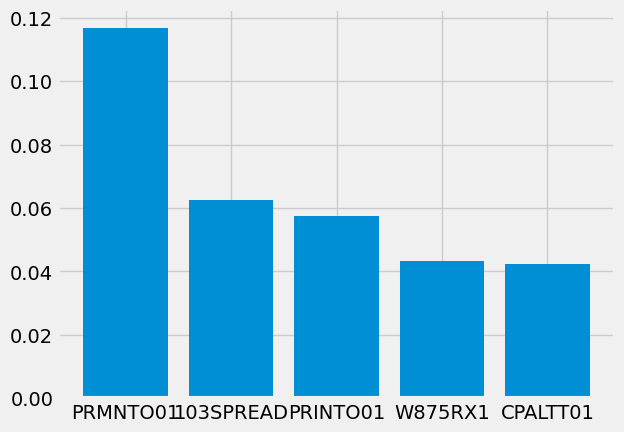

In [155]:
lab_feat_imp = list(zip(list(X_data.columns), list(clf[1].best_estimator_.feature_importances_)))
gb_feats=[x for (x, y) in sorted(lab_feat_imp, key=lambda x: x[1], reverse=True)][:10]

gb_feat_df=pd.DataFrame(sorted(lab_feat_imp, key=lambda x: x[1], reverse=True), columns=['name','feat_imp'])

plt.bar(gb_feat_df.name[:5], gb_feat_df.feat_imp[:5])

gb_feat_df['name']=gb_feat_df['name'].apply(lambda x:metadata[metadata.SUBJECT==x]['Name'].values[0])
gb_feat_df

In [156]:
gb_probs = list(clf[1].best_estimator_.predict_proba(X_data))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


### 2-2. GB model trained with top 10 features


#### set X_data having top 10 features of the previous model

In [157]:
gb_data = X_data[gb_feats]

#### execute grid search for gb model with top 10 features

In [158]:
## execute grid search
########### assign hyperparameters in interest #############################################################
param_gbs=[{'n_estimators':[30, 40, 60, 100],
            'max_depth':[5, 10],
            'learning_rate':[0.2,0.3, 0.5,0.7],
            'max_features':[0.3,0.4, 0.6,0.8],
            }]
y_types=['y_oecd']
test_year=5
n_splits=3
threshold=50
############################################################################################################


for param_gb in param_gbs:
  for y_type in y_types:
    y=raw_df[y_type]
    y_data=y[-(threshold*12+6):-6]
    gb_grid_search(path, gb_data, y_data, y_type, n_splits, test_year, param_gb)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


#### find out the best parameter combination for gb model with top 10 features

In [159]:
y_types=['y_oecd']

dict_gb={}

for y_type in y_types:
  with open (path+'/model/clf_{}_gb.pkl'.format(y_type), 'rb') as f:
      [clf, df_cvresult, y_pred, y_pred_prob, clf_report]=pickle.load(f)
      dict_gb['clf_{}_gb.pkl'.format(y_type)]=[clf, df_cvresult, y_pred, y_pred_prob, clf_report]

for idx, model in enumerate(dict_gb):
    if idx==0:
        df_gb=dict_gb[model][1]
    else:
        df_tmp=dict_gb[model][1]
        df_gb=pd.concat([df_gb, df_tmp])

df_gb[df_gb.rank_test_recall_macro==1]

,learning_rate,max_depth,max_features,n_estimators,model,y_type,mean_test_recall_macro,std_test_recall_macro,rank_test_recall_macro
76,0.5,5,0.8,30,GB,y_oecd,0.621615,0.062264,1


#### find out the performance of the best model for the final test dataset

In [160]:
for idx, model in enumerate(dict_gb.keys()):

    report=dict_gb[model][-1]
    y_pred=dict_gb[model][-3]
    y_test=y_data.iloc[-test_year*12:]

    auc=roc_auc_score(y_test, y_pred)

    if idx==0:
        df_gb_creport=classification_report_csv(report)
        df_gb_creport['model']=model
        df_gb_creport['roc_auc']=auc
    else:
        df_tmp=classification_report_csv(report)
        df_tmp['model']=model
        df_gb_creport=pd.concat([df_gb_creport, df_tmp])
        df_gb_creport['roc_auc']=auc

df_gb_creport

,class,precision,recall,f1_score,support,accuracy,model,roc_auc
0,0.0,0.92,0.62,0.74,56.0,0.6,clf_y_oecd_gb.pkl,0.4375
1,1.0,0.05,0.25,0.08,4.0,0.6,clf_y_oecd_gb.pkl,0.4375


#### figure out top features and recession probabilities of the best model

,name,feat_imp
0,10YT-3MTBILL,0.217866
1,Production Industry Total industry Total indus...,0.203907
2,Real personal income excluding current transfe...,0.130230
3,Production Manufacturing Total manufacturing T...,0.093860
4,3 Month Treasury Bill Yield,0.086527
5,Consumer Price Index All items Total Total,0.067734
6,Interest Rates 3-month or 90-day rates and yie...,0.054290
7,Labour Force Survey - quarterly levels Employe...,0.051892
8,Consumer opinion surveys Confidence indicators...,0.051507
9,Interest Rates 3-month or 90-day rates and yie...,0.042187


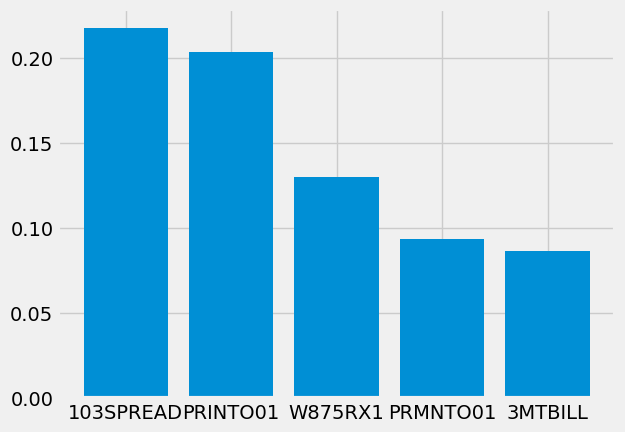

In [161]:
lab_feat_imp = list(zip(list(gb_data.columns), list(clf[1].best_estimator_.feature_importances_)))
gb_feat_df_top=pd.DataFrame(sorted(lab_feat_imp, key=lambda x: x[1], reverse=True), columns=['name','feat_imp'])

plt.bar(gb_feat_df_top.name[:5], gb_feat_df_top.feat_imp[:5])

gb_feat_df_top['name']=gb_feat_df_top['name'].apply(lambda x:metadata[metadata.SUBJECT==x]['Name'].values[0])
gb_feat_df_top

In [162]:
gb_sel_probs = list(clf[1].best_estimator_.predict_proba(gb_data))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


## Integrating and Storing the results of all RF and GB models

In [163]:
dict_list=[df_rf, df_rf_creport, df_gb, df_gb_creport]
id_list=['df_rf', 'df_rf_creport', 'df_gb', 'df_gb_creport']

for i, dict_ in enumerate(dict_list):
    with open(path+'/model/{}.pkl'.format(id_list[i]), 'wb') as f:
        pickle.dump(dict_, f)